# Decision Tree

In this example, we look at the performance of a simple [decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) from the Scikit-Learn package.

We will use the [adult](https://archive.ics.uci.edu/ml/datasets/adult) that focuses on a (binary) classification task whether or not a person makes more than 50k USD per year. The data are taken from a 1994 census and were first discussed in the paper [Ron Kohavi, "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996](https://www.academia.edu/download/40088603/Scaling_Up_the_Accuracy_of_Naive-Bayes_C20151116-5477-1fw84ob.pdf)

The data have a number of categorial and numerical features.
We can access the data directly from the archive (or use a local copy).

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
import seaborn as sns

## Data Access

Read in data directly from the archive.

In [2]:
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]



We take a first look at the data.
One thing we notice is that the categorial data are not in numerical format - this is helpful for us to understand the data, but few algorithms will be able to use the data as they are.
Further, the target column ("Income") is text as well, which we need to transform to a numberical representation: (0,1).

In [3]:
df.head(5)

Age          WorkClass  fnlwgt   Education  EducationNum  \
0   39          State-gov   77516   Bachelors            13   
1   50   Self-emp-not-inc   83311   Bachelors            13   
2   38            Private  215646     HS-grad             9   
3   53            Private  234721        11th             7   
4   28            Private  338409   Bachelors            13   

         MaritalStatus          Occupation    Relationship    Race   Gender  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   CapitalGain  CapitalLoss  HoursPerWeek   NativeCountry  Income  
0         2174            0            40   United-States   <=50K  
1            0            0            13   United-States   <=50K  
2            0            0            40   United-States   <=50K  
3            0            0            40   United-States   <=50K  
4            0            0            40            Cuba   <=50K

# Exploratory Data Analaysis

As a first step, we look at the variables to understand how the target we want to predict is correlated with the features.

The function ```displot``` from the [Seaborn](https://seaborn.pydata.org/) package can handle the text values from the data directly.

***Exercise***

Explore the influence of the various variables on the target, e.g. the education level, gender or race.
Try to understand if or how the behaviour you see would make sense with your understanding.

In [4]:
sns.displot(data=df,y='Education',hue='Income')
plt.xlabel('count', size = 20)
plt.ylabel('Education', size = 20)
plt.show()

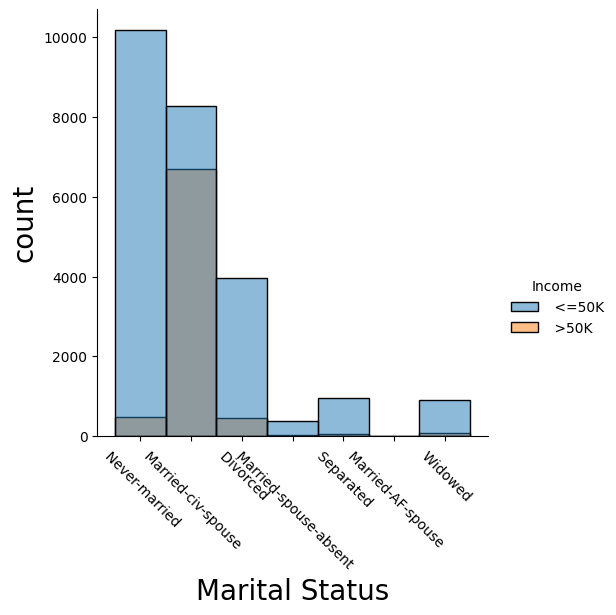

In [5]:
sns.displot(data=df,x='MaritalStatus',hue='Income')
plt.ylabel('count', size = 20)
plt.xlabel('Marital Status', size = 20)
plt.xticks(rotation=-45)
plt.show()

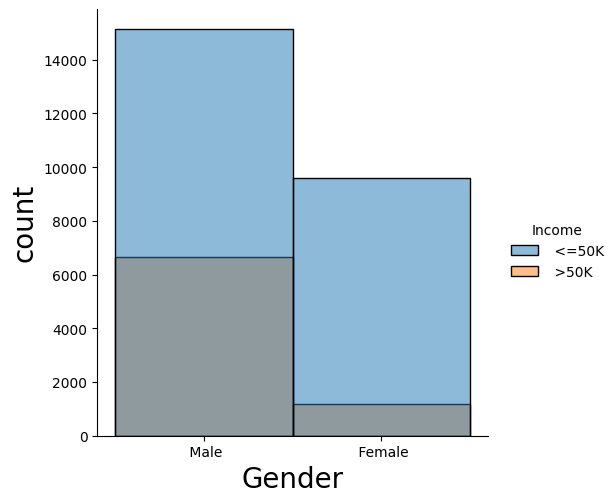

In [9]:
sns.displot(data=df,x='Gender',hue='Income')
plt.ylabel('count', size = 20)
plt.xlabel('Gender', size = 20)
plt.show()

In [6]:
sns.displot(data=df,x='Race',hue='Income')
plt.ylabel('count', size = 20)
plt.xlabel('Race', size = 20)
plt.xticks(rotation=-45)
plt.show()

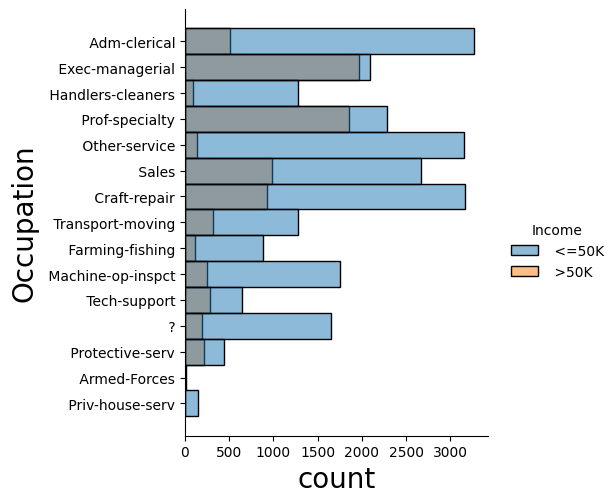

In [7]:
sns.displot(data=df,y='Occupation',hue='Income')
plt.xlabel('count', size = 20)
plt.ylabel('Occupation', size = 20)
plt.show()

We can also look at variables with (continuous) numerical values. 
These are binned and we use a histogram which allows us to examine the behaviour of the feature variable w.r.t. the target.
If you look at the variable ```HoursPerWeek```, using 20 bins works quite well.
Note the strong peak at 40 hours (default work week), so use a log-scale for the ```y```-axis.

In [8]:
g = sns.histplot(data=df, x='HoursPerWeek', hue='Income',bins=20)
g.set_yscale("log")
plt.ylabel('count', size = 20)
plt.xlabel('Hours per week', size = 20)
plt.show()

In [14]:
df.isna().sum()

Age              0
WorkClass        0
fnlwgt           0
Education        0
EducationNum     0
MaritalStatus    0
Occupation       0
Relationship     0
Race             0
Gender           0
CapitalGain      0
CapitalLoss      0
HoursPerWeek     0
NativeCountry    0
Income           0
dtype: int64

## Data Preparation

In order to work with the data further, we need to convert the text in the categorial variables into numerical values.
Pandas provides a datatype ```category``` which we can use for this purpose. 
As a first step, we need to change the variable type of the respective columns to this datatype.

Then, in the next step, we can use ```.cat.codes``` to access a numerical representation.
An alternative would be to use "One-Hot-Encoding". Pandas provides a utitlity function for this called [get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).


In [4]:
# Unique categories for the column "WorkClass"
df['WorkClass'].unique().tolist()

[' State-gov',
 ' Self-emp-not-inc',
 ' Private',
 ' Federal-gov',
 ' Local-gov',
 ' ?',
 ' Self-emp-inc',
 ' Without-pay',
 ' Never-worked']

In [128]:
# Change the data type.
df = df.astype({'WorkClass': 'category', 'Education': 'category', 'MaritalStatus' : 'category', 'Occupation' : 'category', 
'Relationship' : 'category', 'Race' : 'category', 'Gender': 'category', 'NativeCountry': 'category' })

In [129]:
# see how this has worked
df['Education'].dtype

CategoricalDtype(categories=[' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th',
                  ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc',
                  ' Bachelors', ' Doctorate', ' HS-grad', ' Masters',
                  ' Preschool', ' Prof-school', ' Some-college'],
, ordered=False)

In [130]:
# access the numerical representation
df['Education'].cat.codes

0         9
1         9
2        11
3         1
4         9
         ..
32556     7
32557    11
32558    11
32559    11
32560    11
Length: 32561, dtype: int8

In [8]:
# select all columns with the datatype "category"
cat_columns = df.select_dtypes(['category']).columns
print(cat_columns)

Index(['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 'Relationship',
       'Race', 'Gender', 'NativeCountry'],
      dtype='object')


In [131]:
#convert all text to numerical values
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)


In [132]:
df.head(5)

Age  WorkClass  fnlwgt  Education  EducationNum  MaritalStatus  Occupation  \
0   39          7   77516          9            13              4           1   
1   50          6   83311          9            13              2           4   
2   38          4  215646         11             9              0           6   
3   53          4  234721          1             7              2           6   
4   28          4  338409          9            13              2          10   

   Relationship  Race  Gender  CapitalGain  CapitalLoss  HoursPerWeek  \
0             1     4       1         2174            0            40   
1             0     4       1            0            0            13   
2             1     4       1            0            0            40   
3             0     2       1            0            0            40   
4             5     2       0            0            0            40   

   NativeCountry  Income  
0             39   <=50K  
1             39   <=50K  
2             39   <=50K  
3             39   <=50K  
4              5   <=50K

As the next step, we need to separate the data (-frame) into arrays that contain the features we want to use in the machine learning approach (```X```), and the corresponding labels (```y```).
Since the label is also represented by text, we first need to convert this into a numerical representation as 0 and 1.

Note:
- we know that the target/label is in the last column, i.e. all other columns are the features we want to use
- we can use a ```lambda``` function to efficiently process each row in the table to transform the values for the target/labels. You need to use the ```apply``` method to work on each individual data record (rows) in bulk.

***Exercise:***
fill in the code below.

In [16]:

# the target column is the last column (Income)
train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
#Turning response into 0 and 1
y = df[label].apply(lambda x: 0 if x == " <=50K" else 1) 

To follow best practices, we keep split the data into separate samples that we use for training and evaluation of our model.
The test data are only used in the evaluation to be able to verify the performance on an independent sample.

In [17]:
# split into training and test sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [18]:
y_train.describe()

count    24420.000000
mean         0.239967
std          0.427072
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Income, dtype: float64

Here we setup our model. In this example we use a simple decision tree.
The parameter ```random_state=0``` makes the model more deterministic, see the [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for details.

Since the dataset is quite small, the default values will result in a very good model. Here, we increase the minimum number of samples in the leaves to reduce the flexibility and prevent splits such that the tree can learn each category by heart. This should limit overtraining a bit - and is also needed to demonstrate the behaviour of predicting probabilities in this example.
We do this by passing the parameter ```min_samples_leaf = 10```

The general procedure to setup a classifier is to:
- define the classifier
- call the ```fit``` method passing the training features (```X```), and labels (```y```)

***Exercise***

Define and train a ```DecisionTreeClassifier```

In [85]:
# default value - good tree, small dataset
#model = DecisionTreeClassifier(random_state=0)
model = DecisionTreeClassifier(random_state=0, min_samples_leaf = 10)
model.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=10, random_state=0)

We can plot the model - as you can see, we can't really "see" much, the tree is quite complex. Therefore, while in principle such a decision tree would be explainable in the sense that we can follow each decision path, the complexity of even this fairly simple model is already high enough that we cannot really gain many insights from looking at the tree itself.

In [126]:
plot_tree(model)
plt.show()

## Predictions

We now use the model on the test data to derive predictions. We take a (deep) copy of the test data to be able to manipulate the dataframe and not touch the original test data.

We access the predictions with
- ```model.predict(X_test)``` for a binary (0/1) output
- ```model.predict_proba(X_test)``` for the probability for each class.

```predict_proba``` returns an array for each prediction. Since we only have two classes in this example, the first value for each prediction is for the first class (```y=0```), the second for the other class (```y=1```).
In case we had more classes, there would be more numbers and we could, for example, assign the class with the highes probability and/or require that each assignment also exceeds a certain threshold.

For convenience, we append the predictions (and the true labels) to the copy of the test data. This allows us to look at a few values and also collects all information in a single dataframe

In [101]:
predictions = X_test.copy()
y_hat = model.predict(predictions)
y_hat_proba = model.predict_proba(predictions)
predictions.loc[:,'y_hat'] = y_hat
predictions.loc[:,'y_hat_proba_class1'] = y_hat_proba[:,1]
predictions.loc[:,'y'] = y_test

In [102]:
predictions.head(15)

Age  WorkClass   fnlwgt  Education  EducationNum  MaritalStatus  \
8236    42          4    52781         15            10              2   
2152    21          0   300812         15            10              4   
4490    29          4   107458          9            13              4   
12833   36          4   240323         15            10              6   
19947   34          4   269723         11             9              0   
7169    54          4    94055          9            13              2   
19603   44          4   216907         11             9              0   
19013   33          4   379798         11             9              2   
23049   65          4   171584          9            13              4   
32101   45          4   174794          9            13              5   
25960   27          4   159897         11             9              4   
24855   25          4    44363         11             9              4   
5029    17          4   121037          2             8              4   
8643    43          0   116632         15            10              2   
15569   29          4  1268339         11             9              3   

       Occupation  Relationship  Race  Gender  CapitalGain  CapitalLoss  \
8236           13             0     4       1            0            0   
2152            0             3     4       1            0            0   
4490           12             1     4       1            0            0   
12833           1             4     2       0            0            0   
19947           4             4     4       0         2977            0   
7169            8             0     4       1            0            0   
19603           8             1     4       1            0            0   
19013           3             0     4       1            0            0   
23049           4             1     4       1            0            0   
32101          10             4     4       0            0            0   
25960           4             1     2       0            0            0   
24855           6             1     4       1            0            0   
5029           12             3     4       0            0            0   
8643            0             0     4       1            0            0   
15569          13             3     2       1            0            0   

       HoursPerWeek  NativeCountry  y_hat  y_hat_proba_class1  y  
8236             40             39      1            0.578947  0  
2152             30             39      0            0.000000  0  
4490             50             39      0            0.230769  0  
12833            40             39      0            0.000000  0  
19947            50             39      0            0.000000  0  
7169             40             39      0            0.461538  0  
19603            37             39      0            0.000000  0  
19013            40             39      0            0.333333  0  
23049            40             39      0            0.000000  0  
32101            56             11      0            0.166667  0  
25960            37             39      0            0.000000  0  
24855            35             39      0            0.000000  0  
5029             15             39      0            0.000000  0  
8643             45             39      1            0.727273  1  
15569            40             39      0            0.000000  0

## Evaluation

Now we evaluate how well our classifier works.

A good way to visualise this is the confusion matrix for the binary labels and predictions.
This allows us to see if the predictions are generally quite good (most entries on the diagonal line) and how many off-diagonal elements we have that indicate wrong class assignments.

Here, we normalise the values displayed in the confusion matrix to the number of all entries to get the relative proportions

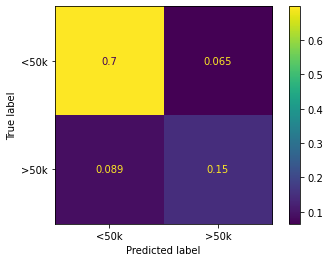

In [133]:
cm = metrics.confusion_matrix(y_test, y_hat,normalize='all')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['<50k', '>50k'])
disp.plot()
plt.show()

Scikit-Learn also provides a summary report with the most important metrics:

In [108]:
print(metrics.classification_report(y_test, y_hat, target_names=['<50k', '>50k']))

              precision    recall  f1-score   support

        <50k       0.89      0.92      0.90      6213
        >50k       0.70      0.63      0.66      1928

    accuracy                           0.85      8141
   macro avg       0.79      0.77      0.78      8141
weighted avg       0.84      0.85      0.84      8141



A key plot to understand the performance is the ROC curve.
Here, we need probabilities and the curve is constructed by setting subsequent thresholds on the predictied probabilies.
A model that is only as good as random guessing would lie on the diagonal, the ideal point is (0,1) where all predictions are perfect.

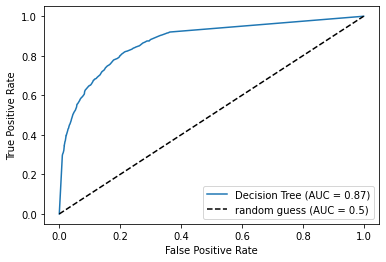

In [121]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat_proba[:,1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Decision Tree')

display.plot()
# diagonal line
plt.plot([0, 1], [0, 1], "k--", label="random guess (AUC = 0.5)")
plt.legend()
plt.show()